### Load Data & libraries

In [9]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import seaborn as sns
import warnings

# import LibESN
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN
from LibESN.esn_fit import ridgeFit, ridgeCV
from LibESN.esn_forecast import forecast
from ModelConfidenceSet import ModelConfidenceSet


In [10]:
# Load data
data = read_csv(r"C:\Users\zhouq\OneDrive - Nanyang Technological University\FYP\Codes\FYP\Data_transform.csv", header = 0, index_col=0, parse_dates=True, dayfirst=False)

# Select 3 exogenous variables 
# M1: Industrial Production Index
# M7: Retail and Food Services Sale
# M12: Effective Federal Funds Rate 

data_new = data[['GDP', 'M1', 'M4', 'M5','M7','M11','M12']]
data_new = data_new.dropna()
print(len(data_new))

# Split the data into training and testing sets
train_size = int(len(data_new) * 0.8)
print(train_size)

GDP_fill_data  = pd.DataFrame(data_new['GDP'])
GDP_fill_data.index = GDP_fill_data.index + pd.offsets.QuarterEnd(0)
GDP_fill_data_train, GDP_fill_data_test = GDP_fill_data[:train_size], GDP_fill_data[train_size:]
display(GDP_fill_data)

x_data = pd.DataFrame(data_new.iloc[:, 1:])
x_data.index = x_data.index + pd.offsets.QuarterEnd(0)
x_train, x_test = x_data[:train_size], x_data[train_size:]
display(x_train)
display(x_test)


187
149


,GDP
Date,
1973-06-30,0.010828
1973-09-30,-0.005273
1973-12-31,0.009447
1974-03-31,-0.008635
1974-06-30,0.002374
...,...
2018-12-31,0.002229
2019-03-31,0.005960
2019-06-30,0.007898


,M1,M4,M5,M7,M11,M12
Date,,,,,,
1973-06-30,0.002169,0.002625,7.667223,0.000596,-0.006008,0.466667
1973-09-30,0.003508,0.001682,7.607500,0.005545,-0.001006,0.763333
1973-12-31,0.003204,0.003241,7.402523,-0.004285,0.013432,-0.276667
1974-03-31,-0.003244,0.001130,7.365917,0.010897,-0.001898,-0.200000
1974-06-30,0.001065,0.001309,7.322201,0.009025,-0.003644,0.860000
...,...,...,...,...,...,...
2009-06-30,-0.007081,-0.003805,6.277597,0.010092,-0.029533,0.010000
2009-09-30,0.010157,-0.001950,6.377270,-0.001352,-0.013036,-0.020000
2009-12-31,0.003319,-0.001169,6.340625,0.007367,-0.003672,-0.010000


,M1,M4,M5,M7,M11,M12
Date,,,,,,
2010-09-30,0.003310,-0.000394,6.361587,0.005330,-0.017265,0.003333
2010-12-31,0.002587,0.001187,6.295870,0.008849,-0.005356,-0.003333
2011-03-31,0.001333,0.001185,6.363564,0.008423,-0.013786,-0.013333
2011-06-30,0.000213,0.001649,6.352353,0.003989,-0.005872,-0.016667
2011-09-30,0.003528,0.001057,6.427710,0.003780,0.008346,-0.003333
2011-12-31,0.003901,0.001352,6.507534,0.003507,0.009549,-0.003333
2012-03-31,0.001268,0.002140,6.561366,0.008449,-0.001909,0.020000
2012-06-30,0.003045,0.000635,6.605291,-0.005081,0.009676,0.010000
2012-09-30,-0.000781,0.001269,6.657914,0.008297,-0.011243,-0.006667


In [11]:
def normalize_train_test(train, test, return_mu_sig=False):
    m_train = train.mean()
    s_train = (train - train.mean()).std()
    if return_mu_sig:
        return (train - m_train)/s_train, (test - m_train)/s_train, m_train, s_train
    else:
        return (train - m_train)/s_train, (test - m_train)/s_train
    

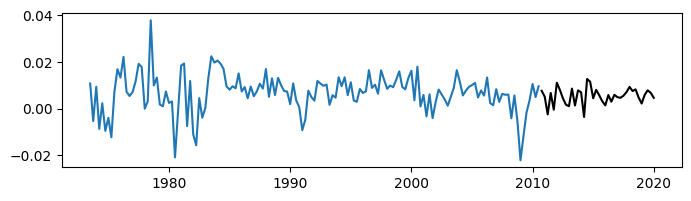

In [12]:
# plot dataset
plt.figure(figsize=(8,2))
plt.plot(GDP_fill_data_train, label = 'Train')
plt.plot(GDP_fill_data_test, label = 'Test', color = 'black')

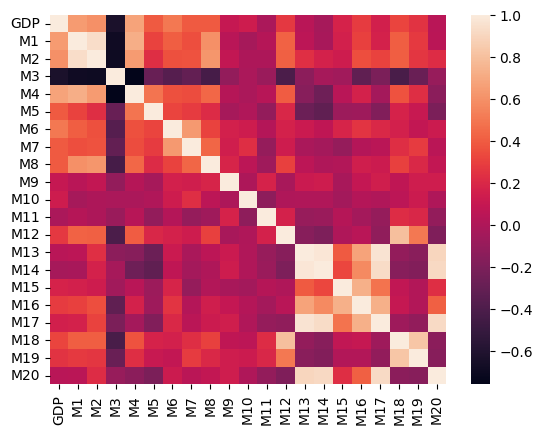

In [13]:
# check correlations between variables
corr_matrix_all = sns.heatmap(data.corr(), annot=False)

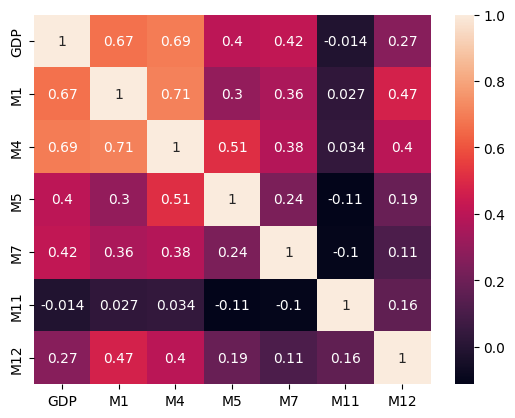

In [14]:
corr_matrix = sns.heatmap(data_new.corr(), annot=True)

### Models

#### ESN

In [15]:
# construct individual ESN
# K is size of inputs 
K = int(x_data.shape[1])
print(int(x_data.shape[1]))

# ESN with reservoir dim = 20 , sparsity = 10/20 (50%)
esn_a = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((20 , 20), dist='sparse_normal', normalize= 'eig', sparsity=10/20, seed=1234), 

    C=matrixGenerator((20, K), dist='sparse_uniform', normalize='norm2', sparsity=10/20, seed=1234), 

    zeta=np.zeros((20, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


6


In [16]:
# build single reservoir ESN with reservoir dim = 30, sparsity = 10/30 (33.3%)

esn_b = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((30, 30), dist='sparse_normal', normalize= 'eig', sparsity=10/30, seed=1234), 

    C=matrixGenerator((30, K), dist='sparse_uniform', sparsity=10/30, normalize='norm2', seed=1234), 

    zeta=np.zeros((30, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [17]:
# ESN with reservoir dim = 80 , sparsity = 10/80 (12.5%)
esn_c = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((80 , 80), dist='sparse_normal', normalize= 'eig', sparsity=10/80, seed=1234), 

    C=matrixGenerator((80, K), dist='sparse_uniform', normalize='norm2', sparsity=10/80, seed=1234), 

    zeta=np.zeros((80, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [18]:
# ESN with reservoir dim = 120, sparsity = 10/120 (8.3%)
esn_d = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((120, 120), dist='sparse_normal', sparsity=10/120, normalize= 'eig', seed=1234), 

    C=matrixGenerator((120, K), dist='sparse_uniform', sparsity=10/120, normalize='norm2', seed=1234), 

    zeta=np.zeros((120, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [19]:
# ESN with reservoir dim = 150, sparsity = 10/150 
esn_e = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((150, 150), dist='sparse_normal', sparsity=10/150, normalize= 'eig', seed=1234), 

    C=matrixGenerator((150, K), dist='sparse_uniform', sparsity=10/150, normalize='norm2', seed=1234), 

    zeta=np.zeros((150, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)

#### ARX

In [20]:
order = (1, 0, 0)  # AR(1)
arx_model = ARIMA(endog=GDP_fill_data_train, exog=x_train, order=order)
arx_fit = arx_model.fit(method='yule_walker')

c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


#### VAR

In [21]:
# choose an optimal lag 
data_new_train, data_new_test = data_new[:train_size], data_new[train_size:]

var_model = sm.tsa.VAR(data_new_train)
var_lag = var_model.select_order(maxlags=8)
var_lag.summary()
# lowest BIC for lag 1

c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-58.50,-58.36,3.908e-26,-58.44
1,-62.57,-61.40*,6.695e-28*,-62.10*
2,-62.56,-60.36,6.823e-28,-61.67
3,-62.47,-59.25,7.555e-28,-61.16
4,-62.31,-58.07,9.017e-28,-60.59
5,-62.34,-57.07,9.168e-28,-60.20
6,-62.16,-55.86,1.163e-27,-59.60
7,-62.14,-54.82,1.293e-27,-59.16
8,-62.61*,-54.27,9.071e-28,-59.22


In [22]:
var_fit = var_model.fit(1)
var_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Mar, 2024
Time:                     18:48:17
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -60.9621
Nobs:                     148.000    HQIC:                  -61.6354
Log likelihood:           3181.10    FPE:                1.07714e-27
AIC:                     -62.0962    Det(Omega_mle):     7.45132e-28
--------------------------------------------------------------------
Results for equation GDP
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.015044         0.020091           -0.749           0.454
L1.GDP        -0.164658         0.107098           -1.537           0.124
L1.M1          0.724384         0.166663            4.346           0.000
L1.M4          0

In [23]:
# Check for autocorrelation
# A value near 2 indicates non-autocorrelation; a value toward 0 indicates positive autocorrelation; a value toward 4 indicates negative autocorrelation

from statsmodels.stats.stattools import durbin_watson
out_dw = durbin_watson(var_fit.resid)

for col, val in zip(data_new[:train_size].columns, out_dw):
    print((col), ':', round(val, 2))

GDP : 1.82
M1 : 2.01
M4 : 1.95
M5 : 1.67
M7 : 1.94
M11 : 1.94
M12 : 2.09


### Model Fitting and Fixed Parameter Forecast

##### ESN

In [24]:
def esn_fit(esnModel, GDP_data, exo_data):
    GDP_train, GDP_test = GDP_data[0], GDP_data[1]
    exo_train, exo_test = exo_data[0], exo_data[1]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    #cross validation to find lambda
    cv = ridgeCV().cv(model= esnModel, train_data=(exo_train, GDP_train), steps = 1, test_size = 5 )

    #fit model
    esnSingle_fit = esnModel.fit(train_data = (exo_train, GDP_train), method= ridgeFit(cv['cvLambda']), steps =1)

    #forecast
    esnSingle_for = forecast(model = esnModel, forecast_data=exo_test, fit=esnSingle_fit)

    # plot 
    plt.figure(figsize=(8,2))
    plt.plot(data_new.index[:len(GDP_train)], GDP_train, label='Train')
    plt.plot(data_new.index[len(GDP_train):],GDP_test, label='Test')
    plt.plot(data_new.index[len(GDP_train):], esnSingle_for['forecast'][1:], label='Predictions')
    plt.grid()
    plt.show()

    # Compute pointwise forecasts by undoing normalization
    esn_forecast = (esnSingle_for['forecast'])* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    #find RMSE
    mse = mean_squared_error(GDP_data[1], esn_forecast[0:len(GDP_test)])
    mae = mean_absolute_error(GDP_data[1], esn_forecast[0:len(GDP_test)])
    rmse = math.sqrt(mse)
    
    #output
    return({'Lambda': cv['cvLambda'], 'rmse': rmse, 'MAE':mae,'forecast': esn_forecast})

                            

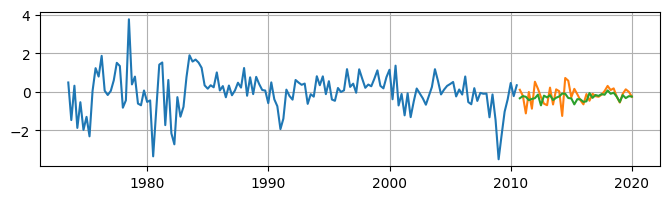

In [25]:
esn_fit_a = esn_fit(esn_a, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

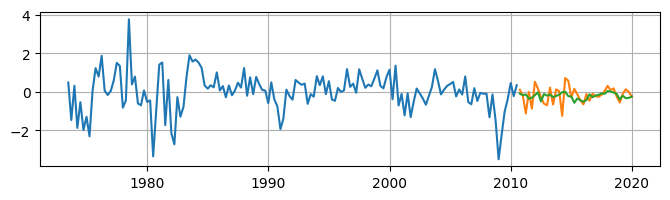

In [26]:
esn_fit_b = esn_fit(esn_b, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

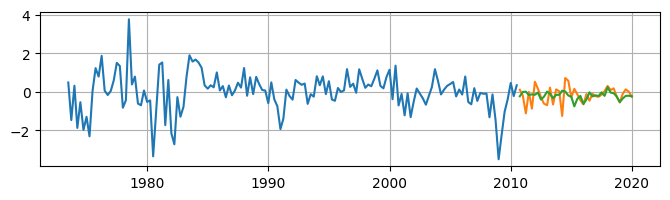

In [27]:
esn_fit_c = esn_fit(esn_c, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

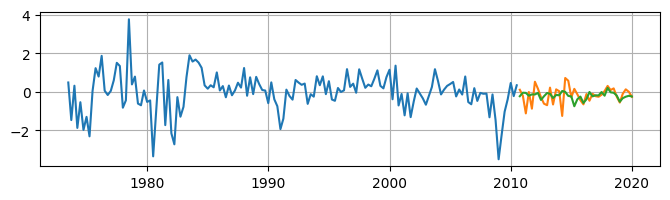

In [28]:
esn_fit_d = esn_fit(esn_d, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

In [30]:
esn_fit_e = esn_fit(esn_e, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

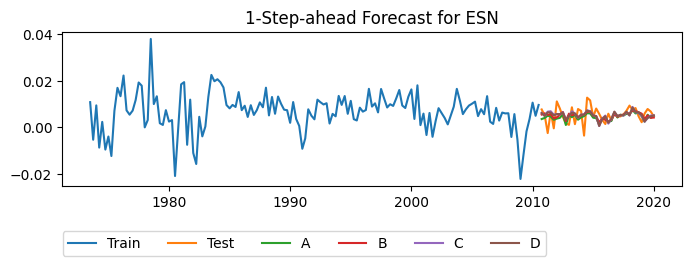

In [ ]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(GDP_fill_data_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(GDP_fill_data_train):],GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_a['forecast'][0:len(GDP_fill_data_test)], label='A')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_b['forecast'][0:len(GDP_fill_data_test)], label='B')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_c['forecast'][0:len(GDP_fill_data_test)], label='C')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_d['forecast'][0:len(GDP_fill_data_test)], label='D')
plt.legend(bbox_to_anchor=(-0.01, -0.5), loc='lower left', ncol =6)
plt.title("1-Step-ahead Forecast for ESN")
plt.show()

#### ARX

In [ ]:
# make predictions - one step ahead forecast
arx_forecast = arx_fit.predict(start=len(x_train), end=len(data_new)-1, exog=x_test)

# Evaluate the model 
mse_arx = mean_squared_error(GDP_fill_data_test, arx_forecast)
print('MSE: '+str(mse_arx))

mae_arx = mean_absolute_error(GDP_fill_data_test, arx_forecast)
print('MAE: '+str(mae_arx))

rmse_arx = math.sqrt(mse_arx)
print('RMSE: '+str(rmse_arx))

MSE: 1.3913421779990817e-05
MAE: 0.00273793323943792
RMSE: 0.003730069943042733


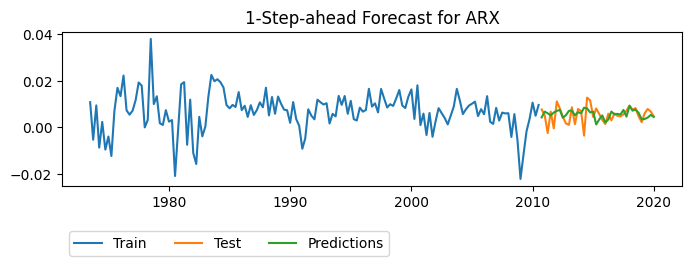

In [ ]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], arx_forecast, label='Predictions')
plt.title("1-Step-ahead Forecast for ARX")
plt.legend(bbox_to_anchor=(0, -0.5), loc='lower left', ncol =3)
plt.show()

#### VAR

In [ ]:
lag_order = var_fit.k_ar
print(lag_order)

# one step ahead GDP forecast
var_forecast = np.zeros((len(GDP_fill_data_test),7))

for i in range(len(GDP_fill_data_test)):
    if i > 0:
        var_fore = var_fit.forecast(data_new_test.values[[i-1]], 1)
        var_forecast[i]= var_fore
    else:
        var_fore = var_fit.forecast(data_new_train.values[-lag_order:], 1)
        var_forecast[i]= var_fore


1


In [ ]:
print(var_forecast[:,0])
rmse_var = np.sqrt(mean_squared_error(GDP_fill_data_test,var_forecast[:,0]))
print('RMSE: '+str(rmse_var))

[ 0.00552588  0.00561976  0.00640393  0.00710666  0.00338832  0.00644021
  0.00500435  0.00574483  0.00310072  0.00560304  0.00716018  0.00570859
  0.00462247  0.00538096  0.00525423  0.00956392  0.00579004  0.00393113
  0.00493161 -0.00125953  0.00204672  0.00451199  0.00064647  0.00254157
  0.00753011  0.00411063  0.00553205  0.00553013  0.00751833  0.00493595
  0.00870394  0.00664972  0.00681589  0.00617774  0.00280861  0.00399815
  0.00363233  0.00429833]
RMSE: 0.0035848577710199214


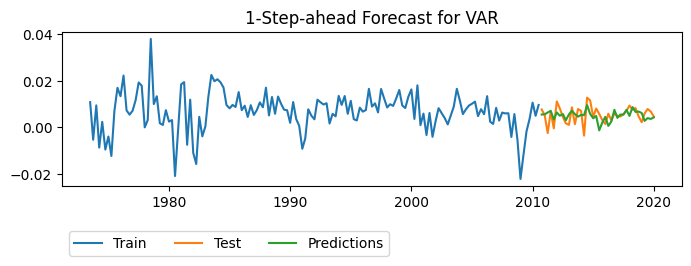

In [ ]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], var_forecast[:,0], label='Predictions')
plt.title("1-Step-ahead Forecast for VAR")
plt.legend(bbox_to_anchor=(0, -0.5), loc='lower left', ncol =3)
plt.show()

#### Summary of RMSE

In [ ]:
rmse_a = esn_fit_a['rmse']
rmse_b = esn_fit_b['rmse']
rmse_c = esn_fit_c['rmse']
rmse_d = esn_fit_d['rmse']
rmse_e = esn_fit_e['rmse']
print("------ RMSE -------")
print(f"ESN_A \t = {round(rmse_a,6)} \t")
print(f"ESN_B \t = {round(rmse_b,6)} \t")
print(f"ESN_C \t = {round(rmse_c,6)} \t")
print(f"ESN_D \t = {round(rmse_d,6)} \t")
print(f"ESN_E \t = {round(rmse_e,6)} \t")
print(f"ARX \t = {round(rmse_arx,6)} \t")
print(f"VAR \t = {round(rmse_var,6)} \t")

------ RMSE -------
ESN_A 	 = 0.003615 	
ESN_B 	 = 0.003434 	
ESN_C 	 = 0.003574 	
ESN_D 	 = 0.003523 	
ESN_E 	 = 0.003506 	
ARX 	 = 0.00373 	
VAR 	 = 0.003585 	


### Expanding window forecast

#### ESN 

In [ ]:
def esn_ew_fit(esnModel, Lambda, GDP_data, x_data, retune=False):
    GDP_fill_data_train = GDP_data[0]
    GDP_fill_data_test = GDP_data[1]

    x_train = x_data[0]
    x_test = x_data[1]

    GDP_test_dates = GDP_fill_data_test.index

    # calculate lambdas
    if retune:
        Lambdas = []
    else:
        Lambdas = Lambda

    forecast_ew = np.zeros((len(GDP_fill_data_test), 1))
    for j in tqdm(range(len(GDP_fill_data_test)), desc="EW", position=1, leave=False):
        if j > 0:
            #update data sets    
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:j,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.iloc[[j],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        x_train_j, x_test_j = (
            normalize_train_test(x_train_j, x_test_j)
        )

        if retune:
            Lambda_j = ridgeCV().cv(
                model= esnModel, 
                train_data=(x_train_j, GDP_fill_data_train_j), 
                steps = 1, 
                test_size = 5)
            
            Lambda_j = Lambda_j['cvLambda']
            Lambdas.append(Lambda_j)
            
        else:
            Lambda_j = Lambda

        #fit model
        esnSingle_fit = esnModel.fit(
            train_data = (x_train_j, GDP_fill_data_train_j), 
            method= ridgeFit(Lambda_j), 
            steps =1)

        #point forecast
        esnSingle_for = forecast(
            model = esnModel, 
            forecast_data=x_test_j, 
            fit=esnSingle_fit)

        forecast_ew[j] = (esnSingle_for['forecast'][0])* sig_j + mu_j #undo normalizing 
        #print(j)

    forecast_ew = pd.DataFrame(data=forecast_ew, index=GDP_test_dates,)
    mse_ew = mean_squared_error(GDP_fill_data_test, forecast_ew)
    rmse_ew = math.sqrt(mse_ew)
    
    return {'forecast': forecast_ew, 'rmse': rmse_ew, 'lambda': Lambdas}
   

In [ ]:
# use pinv and set lambda = 0
esn_A_ew_0 = esn_ew_fit(
    esnModel=esn_a, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_ew_0 = esn_ew_fit(
    esnModel=esn_b, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_ew_0 = esn_ew_fit(
    esnModel=esn_c, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_ew_0 = esn_ew_fit(
    esnModel=esn_d, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_ew_0 = esn_ew_fit(
    esnModel=esn_e, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [ ]:
# evaluate forcast
print("--- RMSE for EW, Lambda = 0 ---")
print(f"ESN_A_EW = {esn_A_ew_0['rmse']} \t")
print(f"ESN_B_EW = {esn_B_ew_0['rmse']} \t")
print(f"ESN_C_EW = {esn_C_ew_0['rmse']} \t")
print(f"ESN_D_EW = {esn_D_ew_0['rmse']} \t")
print(f"ESN_E_EW = {esn_E_ew_0['rmse']} \t")

--- RMSE for EW, Lambda = 0 ---
ESN_A_EW = 0.003862138521604629 	
ESN_B_EW = 0.0049522149729126245 	
ESN_C_EW = 0.005731716367527913 	
ESN_D_EW = 0.009682167213101703 	
ESN_E_EW = 0.09499079641997708 	


In [ ]:
# using a fixed lambda -- same as fixed parms
esn_A_ew = esn_ew_fit(
    esnModel=esn_a, 
    Lambda=esn_fit_a['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_ew = esn_ew_fit(
    esnModel=esn_b, 
    Lambda=esn_fit_b['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_ew = esn_ew_fit(
    esnModel=esn_c, 
    Lambda=esn_fit_c['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_ew = esn_ew_fit(
    esnModel=esn_d, 
    Lambda=esn_fit_d['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_ew = esn_ew_fit(
    esnModel=esn_e, 
    Lambda=esn_fit_e['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [ ]:
# evaluate forcast for fixed lambda
print("---------- RMSE for EW -----------")
print(f"ESN_A_EW = {esn_A_ew['rmse']} \t")
print(f"ESN_B_EW = {esn_B_ew['rmse']} \t")
print(f"ESN_C_EW = {esn_C_ew['rmse']} \t")
print(f"ESN_D_EW = {esn_D_ew['rmse']} \t")
print(f"ESN_E_EW = {esn_E_ew['rmse']} \t")

---------- RMSE for EW -----------
ESN_A_EW = 0.003582423511112043 	
ESN_B_EW = 0.0034446551693035213 	
ESN_C_EW = 0.0035951090888443845 	
ESN_D_EW = 0.003543902011202905 	
ESN_E_EW = 0.003535452626207805 	


#### ARX

In [ ]:
hist_exo = x_train.copy(deep=True)
hist_endo = GDP_fill_data_train.copy(deep=True)
arx_fore_ew = list()
 
#ignore value warnings
warnings.filterwarnings("ignore")

for t in range(len(x_test)):
 # model set up and fit with updated train data
 model = ARIMA(endog=hist_endo, exog=hist_exo, order=order)
 fit = model.fit(method='yule_walker')

 #point forecast
 output = fit.forecast(steps=1, exog = x_test.iloc[t,:])
 
 # update training dataset for the next prediction
 hist_exo = hist_exo._append(x_test.iloc[t,:],ignore_index=False)
 hist_endo = hist_endo._append(GDP_fill_data_test.iloc[t,], ignore_index=False)
 
 # add forecast value to list
 arx_fore_ew.append(output.tolist()[0]) 
 # obs = test.iloc[t,0] # actual
 # print('predicted=%f, actual=%f' % (output, obs))
 
warnings.resetwarnings()

# evaluate forecasts
arx_rmse_ew = math.sqrt(mean_squared_error(GDP_fill_data_test, arx_fore_ew))
print('RMSE: '+str(arx_rmse_ew))

RMSE: 0.0036985768953742594


#### VAR

In [ ]:
var_fore_ew = np.zeros((len(GDP_fill_data_test)))
data_train_ew = data_new_train.copy(deep=True)
data_test_ew = data_new_test.copy(deep=True)

warnings.filterwarnings("ignore")
for i in range(len(x_test)):
    var_model = sm.tsa.VAR(data_train_ew)
    var_fit = var_model.fit(1) # VAR(1)

    #point forecast
    if i > 0:
        var_fore = var_fit.forecast(data_test_ew.values[[i-1]], 1)
        var_fore_ew[i]= var_fore[0][0]

    else: # for i = 0 case, use last value in train 
        var_fore = var_fit.forecast(data_new_train.values[-lag_order:], 1)
        var_fore_ew[i]= var_fore[0][0]
    
    # update training dataset for the next prediction
    data_train_ew = data_train_ew._append(data_test_ew.iloc[i,:],ignore_index=False)
    
warnings.resetwarnings()

# Evaluate     
var_rmse_ew = np.sqrt(mean_squared_error(GDP_fill_data_test, var_fore_ew))
print('RMSE:', var_rmse_ew)

RMSE: 0.0036368839803736924


#### Summary of RMSE for EW

In [ ]:
# evaluate forcast
print("--- RMSE for EW ---")
print(f"ESN_A_EW = {round(esn_A_ew['rmse'],6)} \t")
print(f"ESN_B_EW = {round(esn_B_ew['rmse'],6)} \t")
print(f"ESN_C_EW = {round(esn_C_ew['rmse'],6)} \t")
print(f"ESN_D_EW = {round(esn_D_ew['rmse'],6)} \t")
print(f"ESN_E_EW = {round(esn_E_ew['rmse'],6)} \t")
print(f"ARX_EW \t = {round(arx_rmse_ew,6)} \t")
print(f"VAR_EW \t = {round(var_rmse_ew,6)} \t")

--- RMSE for EW ---
ESN_A_EW = 0.003582 	
ESN_B_EW = 0.003445 	
ESN_C_EW = 0.003595 	
ESN_D_EW = 0.003544 	
ESN_E_EW = 0.003722 	
ARX_EW 	 = 0.003699 	
VAR_EW 	 = 0.003637 	


### Rolling Window Forecast

#### ESN

In [ ]:
def esn_rw_fit(esnModel, Lambda, GDP_data, x_data, retune=False):
    GDP_fill_data_train = GDP_data[0]
    GDP_fill_data_test = GDP_data[1]

    x_train = x_data[0]
    x_test = x_data[1]

    GDP_test_dates = GDP_fill_data_test.index
    GDP_dates = GDP_fill_data_train.index.append(GDP_fill_data_test.index)

    # calculate lambdas
    if retune:
        Lambdas = []
    else:
        Lambdas = Lambda


    forecast_rw = np.zeros((len(GDP_fill_data_test), 1))
    for j in tqdm(range(len(GDP_fill_data_test)), desc="RW", position=1, leave=False):
        if j > 0:
            #update data sets    
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ]).iloc[j:,]
            x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:j,]
            ]).iloc[j:,]
            
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.iloc[[j],]

        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        x_train_j, x_test_j = (
            normalize_train_test(x_train_j, x_test_j)
        )

        if retune:
            Lambda_j = ridgeCV().cv(
                model= esnModel, 
                train_data=(x_train_j, GDP_fill_data_train_j), 
                steps = 1, 
                test_size = 5)
            
            Lambda_j = Lambda_j['cvLambda']
            Lambdas.append(Lambda_j)
            
        else:
            Lambda_j = Lambda

        #fit model
        esnSingle_fit = esnModel.fit(
            train_data = (x_train_j, GDP_fill_data_train_j), 
            method= ridgeFit(Lambda_j), 
            steps =1)

        #point forecast
        esnSingle_for = forecast(
            model = esnModel, 
            forecast_data=x_test_j, 
            fit=esnSingle_fit)

        forecast_rw[j] = (esnSingle_for['forecast'][0])* sig_j + mu_j #undo normalizing 
        #print(j)

    forecast_rw = pd.DataFrame(data=forecast_rw, index=GDP_test_dates,)
    mse_rw = mean_squared_error(GDP_fill_data_test, forecast_rw)
    rmse_rw = math.sqrt(mse_rw)
    
    return {'forecast': forecast_rw, 'rmse': rmse_rw, 'lambda': Lambdas}
   

In [ ]:
# using lamnda = 0
esn_A_rw_0 = esn_rw_fit(
    esnModel=esn_a, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_rw_0 = esn_rw_fit(
    esnModel=esn_b, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_rw_0 = esn_rw_fit(
    esnModel=esn_c, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_rw_0 = esn_rw_fit(
    esnModel=esn_d, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_rw_0 = esn_rw_fit(
    esnModel=esn_e, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [ ]:
# evaluate forcast for lambda = 0 
print("---------- RMSE --------------")
print(f"ESN_A_RW = {esn_A_rw_0['rmse']} \t")
print(f"ESN_B_RW = {esn_B_rw_0['rmse']} \t")
print(f"ESN_C_RW = {esn_C_rw_0['rmse']} \t")
print(f"ESN_D_RW = {esn_D_rw_0['rmse']} \t")
print(f"ESN_E_RW = {esn_E_rw_0['rmse']} \t")

---------- RMSE --------------
ESN_A_RW = 0.0038748767278980307 	
ESN_B_RW = 0.004723803199928089 	
ESN_C_RW = 0.005377231933368742 	
ESN_D_RW = 0.010703060188136042 	
ESN_E_RW = 0.06586872519806634 	


In [ ]:
# using a fixed lambda
esn_A_rw = esn_rw_fit(
    esnModel=esn_a, 
    Lambda=esn_fit_a['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_rw = esn_rw_fit(
    esnModel=esn_b, 
    Lambda=esn_fit_b['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_rw = esn_rw_fit(
    esnModel=esn_c, 
    Lambda=esn_fit_c['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_rw = esn_rw_fit(
    esnModel=esn_d, 
    Lambda=esn_fit_d['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_rw = esn_rw_fit(
    esnModel=esn_e, 
    Lambda=esn_fit_e['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [ ]:
# evaluate forcast for lambda = fixed 
print("--------- RMSE for RW -----------")
print(f"ESN_A_RW = {esn_A_rw['rmse']} \t")
print(f"ESN_B_RW = {esn_B_rw['rmse']} \t")
print(f"ESN_C_RW = {esn_C_rw['rmse']} \t")
print(f"ESN_D_RW = {esn_D_rw['rmse']} \t")
print(f"ESN_E_RW = {esn_E_rw['rmse']} \t")

--------- RMSE for RW -----------
ESN_A_RW = 0.0035179748411564554 	
ESN_B_RW = 0.0034112428688483783 	
ESN_C_RW = 0.0035252506202360944 	
ESN_D_RW = 0.003496937160939644 	
ESN_E_RW = 0.0034951196791203868 	


#### ARX

In [ ]:
hist_exo_rw = x_train.copy(deep=True)
hist_endo_rw = GDP_fill_data_train.copy(deep=True)
arx_fore_rw = list()

warnings.filterwarnings("ignore")

for t in range(len(x_test)):
 # model set up and fit
 model = ARIMA(endog=hist_endo_rw, exog=hist_exo_rw, order=order)
 fit = model.fit(method='yule_walker')
 output = fit.forecast(steps=1, exog = x_test.iloc[t,])
 
 # update training dataset with observed data
 hist_exo = hist_exo.iloc[1:]._append(x_test.iloc[t,:],ignore_index=False)
 hist_endo = hist_endo.iloc[1:]._append(GDP_fill_data_test.iloc[t,], ignore_index=False)
 
 arx_fore_rw.append(output.tolist()[0]) 

warnings.resetwarnings()

# evaluate forecasts
arx_rmse_rw = math.sqrt(mean_squared_error(GDP_fill_data_test, arx_fore_rw))
print('RMSE: '+str(arx_rmse_rw))

RMSE: 0.0037162184397784696


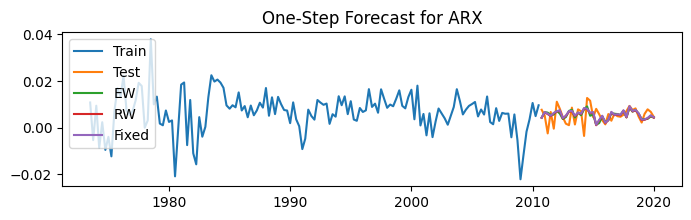

In [ ]:
# plot forecasts against actual outcomes
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], arx_fore_ew, label='EW')
plt.plot(data_new.index[len(x_train):], arx_fore_rw, label='RW')
plt.plot(data_new.index[len(x_train):], arx_forecast, label='Fixed')
plt.title("One-Step Forecast for ARX")
plt.legend()
plt.show()

#### VAR

In [ ]:
var_fore_rw = np.zeros((len(GDP_fill_data_test)))
data_train_rw = data_new_train.copy(deep=True)
data_test_rw = data_new_test.copy(deep=True)

warnings.filterwarnings("ignore")
for i in range(len(x_test)):
    var_model = sm.tsa.VAR(data_train_rw)
    var_fit = var_model.fit(1) # VAR(1)

    #point forecast
    if i > 0:
        var_fore = var_fit.forecast(data_test_rw.values[[i-1]], 1)
        var_fore_rw[i]= var_fore[0][0]

    else: # for i = 0 case, use last value in train 
        var_fore = var_fit.forecast(data_new_train.values[-lag_order:], 1)
        var_fore_rw[i]= var_fore[0][0]
    
    # update training dataset for the next prediction
    data_train_rw = data_train_rw._append(data_test_ew.iloc[i,:],ignore_index=False).iloc[1:,:]
    
warnings.resetwarnings()

# Evaluate     
var_rmse_rw = np.sqrt(mean_squared_error(GDP_fill_data_test, var_fore_rw))
print('RMSE:', var_rmse_rw)

RMSE: 0.003566711300643299


#### Summary of RMSE

In [ ]:
rmse_sum_arx = {'Forecast Methods': ['Fixed Parameters', 'Expanding Window', 'Rolling Window'], 
            'RMSE': [rmse_arx, arx_rmse_ew, arx_rmse_rw ]}

print(pd.DataFrame(rmse_sum_arx).to_string(index=False))

Forecast Methods     RMSE
Fixed Parameters 0.005078
Expanding Window 0.005083
  Rolling Window 0.005120


In [ ]:
rmse_sum_var = {'Forecast Methods': ['Fixed Parameters', 'Expanding Window', 'Rolling Window'], 
            'RMSE': [rmse_var, var_rmse_ew, var_rmse_rw ]}

print(pd.DataFrame(rmse_sum_var).to_string(index=False))

Forecast Methods     RMSE
Fixed Parameters 0.004472
Expanding Window 0.004396
  Rolling Window 0.004341


In [ ]:
# evaluate forcast
print("--- RMSE for RW ---")
print(f"ESN_A_RW = {round(esn_A_rw['rmse'],6)} \t")
print(f"ESN_B_RW = {round(esn_B_rw['rmse'],6)} \t")
print(f"ESN_C_RW = {round(esn_C_rw['rmse'],6)} \t")
print(f"ESN_D_RW = {round(esn_D_rw['rmse'],6)} \t")
print(f"ESN_E_RW = {round(esn_E_rw['rmse'],6)} \t")
print(f"ARX_RW \t = {round(arx_rmse_rw,6)} \t")
print(f"VAR_RW \t = {round(var_rmse_rw,6)} \t")

--- RMSE for RW ---
ESN_A_RW = 0.003518 	
ESN_B_RW = 0.003411 	
ESN_C_RW = 0.003525 	
ESN_D_RW = 0.003497 	
ESN_E_RW = 0.00377 	
ARX_RW 	 = 0.003716 	
VAR_RW 	 = 0.003567 	


### Direct Mutli-step Forecast - Fixed Parameters

#### ESN

In [ ]:
# 8 steps ahead 
from LibESN.esn_forecast import forecastDirectMultistep
def esn_fit_multistep(esnModel, GDP_data, exo_data, n_step):
    GDP_train, GDP_test = GDP_data[0], GDP_data[1]
    exo_train, exo_test = exo_data[0], exo_data[1]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    #cross validation to find lambda
    cv = ridgeCV().cvDirectMultistep(
        model= esnModel, 
        train_data=(exo_train, GDP_train), 
        steps = n_step, 
        test_size = 5 )

    #fit model
    esn_fit_multi = esnModel.fitDirectMultistep(
        train_data = (exo_train, GDP_train), 
        method= ridgeFit(cv['cvLambda']), 
        steps =n_step)

    #forecast
    esn_for = forecastDirectMultistep(
        model = esnModel, 
        forecast_data=exo_test, 
        fit=esn_fit_multi)
    
    #undo norm
    esn_for['forecast'] = esn_for['forecast']* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    #output
    return({'Lambda': cv['cvLambda'], 
            'forecast':esn_for['forecast'],
            'fit': esn_fit_multi})

                            

In [ ]:
esn_a_multistep = esn_fit_multistep(esn_a, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [ ]:
esn_b_multistep = esn_fit_multistep(esn_b, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [ ]:
esn_c_multistep = esn_fit_multistep(esn_c, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [ ]:
esn_d_multistep = esn_fit_multistep(esn_d, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [ ]:
esn_e_multistep = esn_fit_multistep(esn_e, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [ ]:
def hStepRMSFE(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            np.squeeze(GDP_fill_data_test.to_numpy()) - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))


In [ ]:
esn_a_multi_for = np.squeeze(esn_a_multistep['forecast'])
esn_a_multi_for = pd.DataFrame(esn_a_multi_for)
# display(esn_a_multi_for)
print('RMSE for A:',hStepRMSFE(esn_a_multi_for))

esn_b_multi_for = np.squeeze(esn_b_multistep['forecast'])
esn_b_multi_for = pd.DataFrame(esn_b_multi_for)
print('RMSE for B:',hStepRMSFE(esn_b_multi_for))

esn_c_multi_for = np.squeeze(esn_c_multistep['forecast'])
esn_c_multi_for = pd.DataFrame(esn_c_multi_for)
print('RMSE for C:',hStepRMSFE(esn_c_multi_for))

esn_d_multi_for = np.squeeze(esn_d_multistep['forecast'])
esn_d_multi_for = pd.DataFrame(esn_d_multi_for)
print('RMSE for D:',hStepRMSFE(esn_d_multi_for))

esn_e_multi_for = np.squeeze(esn_e_multistep['forecast'])
esn_e_multi_for = pd.DataFrame(esn_e_multi_for)
print('RMSE for E:',hStepRMSFE(esn_e_multi_for))


RMSE for A:           0
1  0.003903
2  0.003908
3  0.003678
4  0.003828
5  0.003848
6  0.004091
7  0.004433
8  0.003981
RMSE for B:           0
1  0.003759
2  0.003745
3  0.003711
4  0.003862
5  0.003942
6  0.004044
7  0.004657
8  0.004000
RMSE for C:           0
1  0.003857
2  0.003735
3  0.003746
4  0.003845
5  0.003884
6  0.003988
7  0.004377
8  0.004059
RMSE for D:           0
1  0.003823
2  0.003699
3  0.003730
4  0.003849
5  0.003873
6  0.003951
7  0.004456
8  0.004003
RMSE for E:           0
1  0.003817
2  0.003679
3  0.003734
4  0.003841
5  0.003862
6  0.003965
7  0.004349
8  0.004009


#### ARX

In [ ]:
# use acf and pacf to predict exogeneous variables
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
x_data

,M1,M4,M5,M7,M11,M12
Date,,,,,,
1973-06-30,0.002169,0.002625,7.667223,0.000596,-0.006008,0.466667
1973-09-30,0.003508,0.001682,7.607500,0.005545,-0.001006,0.763333
1973-12-31,0.003204,0.003241,7.402523,-0.004285,0.013432,-0.276667
1974-03-31,-0.003244,0.001130,7.365917,0.010897,-0.001898,-0.200000
1974-06-30,0.001065,0.001309,7.322201,0.009025,-0.003644,0.860000
...,...,...,...,...,...,...
2018-12-31,-0.000848,0.001212,7.057013,-0.002520,0.007758,0.106667
2019-03-31,-0.003236,0.000788,7.086399,0.009089,-0.000802,0.046667
2019-06-30,-0.001557,0.001012,7.149682,0.003632,-0.000364,-0.010000


In [ ]:
# make predictions - 8 steps ahead forecast
def arx_multistep(steps, data):
    GDP_data_train = data[0]['GDP']
    GDP_data_test = data[1]['GDP']
    x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index

    #set up ARX model forecast
    model_arx = ARIMA(endog=GDP_data_train, exog=x_train, order=order)

    fit_arx = model.fit(method='yule_walker')

    forecast_multistep = np.zeros((len(GDP_test_dates), steps))

    for j in range (len(GDP_data_test)):
        if (j +steps) <= len(GDP_data_test):
            forecast_multistep[j, :] = fit.forecast(steps= steps, exog = x_test.iloc[j:j+steps,:])

        else:
            # use AR to predict the exo terms; used all available data up to time step (train_size)+j
            # M1 is AR(1)
            model_M1 = AutoReg(x_data.iloc[:train_size+j,0], lags=1)
            M1 = model_M1.fit()
            pred_M1 = M1.predict(start = len(x_train)+j, end = len(x_train) +j + steps -1)

            # M4 is AR(1)
            model_M4 = AutoReg(x_data.iloc[:train_size+j,1], lags=1)
            M4 = model_M4.fit()
            pred_M4 = M4.predict(start = len(x_train)+j, end = len(x_train)+j + steps -1)

            # M5
            model_M5 = AutoReg(x_data.iloc[:train_size+j,2], lags=1)
            M5 = model_M5.fit()
            pred_M5 = M5.predict(start = len(x_train)+j, end = len(x_train)+j + steps -1)

            # M7 is AR(1)
            model_M7 = AutoReg(x_data.iloc[:train_size+j,3], lags=1)
            M7 = model_M7.fit()
            pred_M7 = M7.predict(start = len(x_train)+j, end = len(x_train)+j + steps -1)

            # M11
            model_M11 = AutoReg(x_data.iloc[:train_size+j,4], lags=1)
            M11 = model_M11.fit()
            pred_M11 = M11.predict(start = len(x_train)+j, end = len(x_train)+j + steps -1)

            # M12 is AR(3)
            model_M12 = AutoReg(x_data.iloc[:train_size+j,5], lags=3)
            M12 = model_M12.fit()
            pred_M12 = M12.predict(start = len(x_train)+j, end = len(x_train)+j + steps -1)

            pred_exo = pd.concat([pred_M1, pred_M4, pred_M5, pred_M7, pred_M11, pred_M12], axis = 1)
            pred_exo.columns = ['M1','M4', 'M5', 'M7', "M11", 'M12']

            # do forecast for GDP
            forecast_multistep[j, :] = fit.forecast(steps= steps, exog = pred_exo)
        

    return pd.DataFrame(data=forecast_multistep, index=GDP_test_dates, columns=range(steps))


In [ ]:
warnings.filterwarnings("ignore")
arx_multi_fore = arx_multistep(steps =8, data=[data_new_train, data_new_test])
warnings.resetwarnings()

arx_multi_fore


,0,1,2,3,4,5,6,7
Date,,,,,,,,
2010-09-30,0.004310,0.006774,0.006049,0.005180,0.006378,0.007090,0.007524,0.004171
2010-12-31,0.006545,0.006080,0.005176,0.006378,0.007090,0.007524,0.004171,0.005220
2011-03-31,0.005851,0.005207,0.006374,0.007091,0.007524,0.004171,0.005220,0.007122
2011-06-30,0.004978,0.006406,0.007086,0.007525,0.004171,0.005220,0.007122,0.007233
2011-09-30,0.006176,0.007118,0.007520,0.004172,0.005220,0.007122,0.007233,0.005181
2011-12-30,0.006889,0.007552,0.004167,0.005220,0.007122,0.007233,0.005181,0.006533
2012-03-30,0.007322,0.004199,0.005216,0.007123,0.007233,0.005181,0.006533,0.006076
2012-06-29,0.003969,0.005248,0.007118,0.007233,0.005181,0.006533,0.006076,0.008461
2012-09-28,0.005018,0.007150,0.007229,0.005182,0.006533,0.006076,0.008461,0.008141


In [ ]:
hStepRMSFE(arx_multi_fore)

,0
1,0.003929
2,0.003969
3,0.003970
4,0.003976
5,0.003968
6,0.003964
7,0.003955
8,0.003957


#### VAR

In [ ]:
var_fore_multi = list()

def var_multistep(steps, data): 
    train = data[0]
    test = data[1]
    GDP_data_train = data[0]['GDP']
    GDP_data_test = data[1]['GDP']
    x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index

    # set up model
    var_model = sm.tsa.VAR(data[0])
    var_fit = var_model.fit(1)

    # forecast multistep 
    var_forecast = np.zeros((len(test), steps))
    for i in range(len(test)):
        if i > 0:
            var_fore = var_fit.forecast(test.values[[i-1]], steps)
            var_forecast[i, :]= var_fore[:,0]
        else:
            var_fore = var_fit.forecast(train.values[-1:], steps)
            var_forecast[i, :]= var_fore[:,0]

    return pd.DataFrame(data=var_forecast, index=GDP_test_dates, columns=range(steps))

In [ ]:
var_multi_fore = var_multistep(steps =8, data=[data_new_train, data_new_test])
display(var_multi_fore)


c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


,0,1,2,3,4,5,6,7
Date,,,,,,,,
2010-09-30,0.005526,0.003277,0.003228,0.002836,0.002741,0.002718,0.002741,0.002789
2010-12-31,0.005620,0.005447,0.004199,0.003551,0.003216,0.003040,0.002971,0.002962
2011-03-31,0.006404,0.004966,0.003534,0.002992,0.002658,0.002521,0.002485,0.002503
2011-06-30,0.007107,0.005430,0.003855,0.003317,0.002963,0.002810,0.002764,0.002774
2011-09-30,0.003388,0.003978,0.003112,0.002729,0.002586,0.002536,0.002550,0.002596
2011-12-30,0.006440,0.003683,0.003313,0.003061,0.002933,0.002907,0.002925,0.002967
2012-03-30,0.005004,0.004055,0.003719,0.003411,0.003302,0.003269,0.003279,0.003311
2012-06-29,0.005745,0.005316,0.004202,0.003817,0.003589,0.003499,0.003479,0.003494
2012-09-28,0.003101,0.002604,0.003390,0.003317,0.003454,0.003529,0.003594,0.003651


In [ ]:
hStepRMSFE(var_multi_fore)

NameError: name 'hStepRMSFE' is not defined

#### Plots for Multi-step

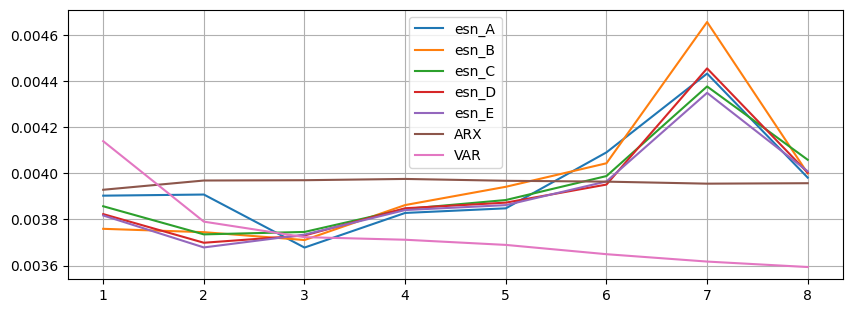

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.grid()
plt.plot(hStepRMSFE(esn_a_multi_for), label="esn_A", c="C0") 
plt.plot(hStepRMSFE(esn_b_multi_for), label="esn_B", c="C1") 
plt.plot(hStepRMSFE(esn_c_multi_for), label="esn_C", c="C2") 
plt.plot(hStepRMSFE(esn_d_multi_for), label="esn_D", c="C3")
plt.plot(hStepRMSFE(esn_e_multi_for), label="esn_E", c="C4")
plt.plot(hStepRMSFE(arx_multi_fore), label="ARX", c="C5") 
plt.plot(hStepRMSFE(var_multi_fore), label="VAR", c="C6")
plt.legend()

### Direct Multi-Step Forecast EW

#### ESN

In [ ]:
def esn_ew_multistep(esnModel, Lambda, GDP_data, x_data, steps, retune=False):
    GDP_fill_data_train = GDP_data[0]
    GDP_fill_data_test = GDP_data[1]

    x_train = x_data[0]
    x_test = x_data[1]

    GDP_test_dates = GDP_fill_data_test.index

    # calculate lambdas
    if retune:
        Lambdas = []
    else:
        Lambdas = Lambda

    for j in tqdm(range(len(GDP_fill_data_test)), desc="EW", position=1, leave=False):
        if j > 0:
            #update data sets    
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:j,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.iloc[[j],]
        else: # if j =0, use original training dataset
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize updated dataset
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        x_train_j, x_test_j = (
            normalize_train_test(x_train_j, x_test_j)
        )

        if retune:
            # use CV to find lambda 
            Lambda_j = ridgeCV().cvDirectMultistep(
                model= esnModel, 
                train_data=(x_train_j, GDP_fill_data_train_j), 
                steps = steps, 
                test_size = 5)
            
            Lambda_j = Lambda_j['cvLambda']
            Lambdas.append(Lambda_j)
            
        else:
            Lambda_j = Lambda

        #fit model
        esn_fit_multi_ew = esnModel.fitDirectMultistep(
            train_data = (x_train_j, GDP_fill_data_train_j), 
            method= ridgeFit(Lambda_j), 
            steps = steps)

        #point forecast
        esn_for = forecastDirectMultistep(
            model = esnModel, 
            forecast_data=x_test_j, 
            fit=esn_fit_multi_ew)

        #undo norm
        esn_for['forecast'] = esn_for['forecast']* sig_j.to_numpy() + mu_j.to_numpy()

    forecast_ew = pd.DataFrame(data=forecast_ew, index=GDP_test_dates,)
    mse_ew = mean_squared_error(GDP_fill_data_test, forecast_ew)
    rmse_ew = math.sqrt(mse_ew)
    
    # outputs
    return {'forecast': forecast_ew, 
            'rmse': rmse_ew, 
            'lambda': Lambdas,
            'fit': esn_fit_multi_ew}
   

SyntaxError: non-default argument follows default argument (2788849402.py, line 1)

In [ ]:
def esn_fit_multistep(esnModel, GDP_data, exo_data, n_step):
    GDP_train, GDP_test = GDP_data[0], GDP_data[1]
    exo_train, exo_test = exo_data[0], exo_data[1]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    #cross validation to find lambda
    cv = ridgeCV().cvDirectMultistep(
        model= esnModel, 
        train_data=(exo_train, GDP_train), 
        steps = n_step, 
        test_size = 5 )

    #fit model
    esn_fit_multi = esnModel.fitDirectMultistep(
        train_data = (exo_train, GDP_train), 
        method= ridgeFit(cv['cvLambda']), 
        steps =n_step)

    #forecast
    esn_for = forecastDirectMultistep(
        model = esnModel, 
        forecast_data=exo_test, 
        fit=esn_fit_multi)
    
    #undo norm
    esn_for['forecast'] = esn_for['forecast']* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    #output
    return({'Lambda': cv['cvLambda'],  
            'forecast':esn_for['forecast'],
            'fit': esn_fit_multi})


### Comparison 
- model confidence set
- pairwise Modified Diehold-Mariano test
    - H0: 2 set of forecasts have the same accuracy
    - H1: different level of accuracy

Prepare the dataset and conduct the tests in R

In [ ]:
mcs_data_fix = pd.DataFrame(np.c_[arx_forecast.values, var_forecast[:,0], esn_fit_a['forecast'][0:len(x_test)], esn_fit_b['forecast'][0:len(x_test)], esn_fit_c['forecast'][0:len(x_test)], esn_fit_d['forecast'][0:len(x_test)], esn_fit_e['forecast'][0:len(x_test)] ], columns = ['ARX', 'VAR', 'ESN_A', 'ESN_B', 'ESN_C', 'ESN_D', 'ESN_E'])

mcs_data_fix.index = data_new_test.index
# mcs_data_fix.to_csv('MCS_Fix.csv', index=True)

In [ ]:
mcs_data_fix = mcs_data_fix - GDP_fill_data_test.to_numpy()


MCS 05 included: ['ESN_E', 'ARX', 'ESN_A', 'ESN_C', 'VAR', 'ESN_D', 'ESN_B']
MCS 10 included: ['ESN_E', 'ARX', 'ESN_A', 'ESN_C', 'VAR', 'ESN_D', 'ESN_B']


In [ ]:
mcs_25_fix = ModelConfidenceSet(data = np.square(mcs_data_fix), alpha=0.25, B=10000, w=2, algorithm='R', seed=1234
).run()

mcs_10_fix = ModelConfidenceSet(
    data=np.square(mcs_data_fix), alpha=0.10, B=10000, w=2, algorithm='R', seed=1234
).run()

mcs_5_fix = ModelConfidenceSet(
    data=np.square(mcs_data_fix), alpha=0.5, B=10000, w=2, algorithm='R', seed=1234
).run()

print(f"MCS 25 included: {mcs_25_fix.included}")
print(f"MCS 10 included: {mcs_10_fix.included}")
print(f"MCS 50 included: {mcs_5_fix.included}")

print('p-values for MCS_25')
print(mcs_25_fix.pvalues)


MCS 25 included: ['ESN_E', 'ARX', 'ESN_A', 'ESN_C', 'VAR', 'ESN_D', 'ESN_B']
MCS 10 included: ['ESN_E', 'ARX', 'ESN_A', 'ESN_C', 'VAR', 'ESN_D', 'ESN_B']
MCS 50 included: ['VAR', 'ESN_D', 'ESN_B']
p-values for MCS_25
ESN_E    0.3304
ARX      0.3304
ESN_A    0.3304
ESN_C    0.3630
VAR      0.7369
ESN_D    0.7369
ESN_B    1.0000
dtype: float64


In [ ]:
mcs_data_ew = pd.DataFrame(np.c_[arx_fore_ew, var_fore_ew,esn_A_ew['forecast'], esn_B_ew['forecast'], esn_C_ew['forecast'], esn_D_ew['forecast'], esn_E_ew['forecast'] ], columns = ['ARX', 'VAR','ESN_A', ' ESN_B', 'ESN_C', 'ESN_D', 'ESN_E'])

mcs_data_ew.index = data_new_test.index
# mcs_data_ew.to_csv('MCS_EW.csv', index=True)
mcs_data_ew = mcs_data_ew - GDP_fill_data_test.to_numpy()


In [ ]:

mcs_25_ew = ModelConfidenceSet(data = np.square(mcs_data_ew), alpha=0.25, B=10000, w=2, algorithm='R', seed=1234
).run()

mcs_10_ew = ModelConfidenceSet(
    data=np.square(mcs_data_ew), alpha=0.10, B=10000, w=2, algorithm='R', seed=1234
).run()

print(mcs_10_fix.pvalues)
print(mcs_25_fix.pvalues)

ESN_E    0.3304
ARX      0.3304
ESN_A    0.3304
ESN_C    0.3630
VAR      0.7369
ESN_D    0.7369
ESN_B    1.0000
dtype: float64
ESN_E    0.3304
ARX      0.3304
ESN_A    0.3304
ESN_C    0.3630
VAR      0.7369
ESN_D    0.7369
ESN_B    1.0000
dtype: float64


In [ ]:
esn_E_rw_retune = esn_E_rw['forecast'].to_csv('esn_E_rw_forecast.csv', index = True)

In [ ]:
mcs_data_rw = pd.DataFrame(np.c_[arx_fore_rw, var_fore_rw, esn_A_rw['forecast'], esn_B_rw['forecast'], esn_C_rw['forecast'], esn_D_rw['forecast'], esn_E_rw['forecast'] ], columns = ['ARX','VAR', 'ESN_A', ' ESN_B', 'ESN_C', 'ESN_D', 'ESN_E'])

mcs_data_rw.index = data_new_test.index
# mcs_data_rw.to_csv('MCS_RW.csv', index=True)

In [ ]:
def MCS_include_stars(m, mcs25, mcs10):
    s = ''
    if m in mcs25.included: s+= '*'
    if m in mcs10.included: s+= '*'
    #if not s == '': s = '$' + s + '$'
    return s

def MCS_stars(mcs25, mcs10):
    methods_25 = list(mcs25.names)
    methods_10 = list(mcs10.names)
    assert methods_25 == methods_10, "MCS test objects have different method names!"
    return [MCS_include_stars(m, mcs25, mcs10) for m in methods_25]

In [ ]:
method_names = ['ARX', 'VAR(1)','ESN [A]', 'ESN [B]', 'ESN [C]', 'ESN [D]', 'ESN [E]']

table_mcs = pd.DataFrame(dict(method = method_names,RMSE_Fix = [rmse_arx, rmse_var, esn_fit_a['rmse'], esn_fit_b['rmse'], esn_fit_c['rmse'], esn_fit_d['rmse'], esn_fit_e['rmse']], Fix =MCS_stars(mcs_25_fix, mcs_10_fix)))

table_mcs

,method,RMSE_Fix,Fix
0,ARX,0.003730,**
1,VAR(1),0.003585,**
2,ESN [A],0.003615,**
3,ESN [B],0.003434,**
4,ESN [C],0.003574,**
5,ESN [D],0.003523,**
6,ESN [E],0.003759,**


In [ ]:
# save all multi-step forecasts into csv files 
# DO not run
esn_a_multi_for.to_csv('multi_fore_ESN_A.csv', index=True)
esn_b_multi_for.to_csv('multi_fore_ESN_B.csv', index=True)
esn_c_multi_for.to_csv('multi_fore_ESN_C.csv', index=True)
esn_d_multi_for.to_csv('multi_fore_ESN_D.csv', index=True)
esn_e_multi_for.to_csv('multi_fore_ESN_E.csv', index=True)
arx_multi_fore.to_csv('multi_fore_ARX.csv', index=True)
var_multi_fore.to_csv('multi_fore_VAR.csv', index=True)
